In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Dense, Rescaling
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import splitfolders
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers, models
import keras
from datasets import load_dataset
import requests
from PIL import Image


In [3]:
from datasets import load_dataset
import requests
from PIL import Image
import os

# Define the dataset name and split (train, test, etc.)
dataset_name = "manojdilz/facial_emotion_detection_dataset"
split_name = "train"

# Load the dataset
dataset = load_dataset(dataset_name, split_name)

# Access and save the image data
data = dataset[split_name]
output_folder = "/Users/navyakrishnabatchu/Downloads/Faces"  # Adjust the path accordingly

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

for example in data:
    # Replace these with the actual keys from your dataset
    image_data = example["image"]
    label = str(example["label"])  # Convert label to string

    # Create a subfolder for each label
    label_folder = os.path.join(output_folder, label)
    os.makedirs(label_folder, exist_ok=True)

    # Save image directly
    image_path = os.path.join(label_folder, f"image_{label}.png")
    image_data.save(image_path)

print("Images downloaded and saved successfully.")


Found cached dataset imagefolder (/Users/navyakrishnabatchu/.cache/huggingface/datasets/manojdilz___imagefolder/manojdilz--facial_emotion_detection_dataset-64a97c29b31aaa9a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

Images downloaded and saved successfully.


In [2]:
def load_images_from_folder(folder):
    images = []
    labels = []

    for expression in os.listdir(folder):
        expression_folder = os.path.join(folder, expression)
        if os.path.isdir(expression_folder):
            for filename in os.listdir(expression_folder):
                img_path = os.path.join(expression_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (48, 48))
                    images.append(img)
                    labels.append(expression)

    return np.array(images), np.array(labels)


### Data Preprocessing

In [3]:
# Define the path to the folder containing the FER2013 dataset
dataset_folder = "/Users/navyakrishnabatchu/Downloads/Faces/train"

# Load images and labels from the dataset
images, labels = load_images_from_folder(dataset_folder)

# Print some information for debugging
print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {np.unique(labels)}")

# Convert labels to one-hot encoded format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Print some information for debugging
print(f"Encoded labels: {encoded_labels}")
print(f"Number of unique encoded labels: {len(np.unique(encoded_labels))}")



Number of images: 28709
Number of labels: 28709
Unique labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Encoded labels: [3 3 3 ... 1 1 1]
Number of unique encoded labels: 7


In [4]:
imagesbyhalf = images[:15000]
labelsbyhalf = labels[:15000]

# Print some information for debugging
print(f"Number of images: {len(imagesbyhalf)}")
print(f"Number of labels: {len(labelsbyhalf)}")
print(f"Unique labels: {np.unique(labelsbyhalf)}")

# Convert labels to one-hot encoded format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labelsbyhalf)
# Print some information for debugging
print(f"Encoded labels: {encoded_labels}")
print(f"Number of unique encoded labels: {len(np.unique(encoded_labels))}")

Number of images: 15000
Number of labels: 15000
Unique labels: ['fear' 'happy' 'sad']
Encoded labels: [1 1 1 ... 0 0 0]
Number of unique encoded labels: 3


In [5]:
# Convert labels to one-hot encoded format
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Convert labels to one-hot encoded format
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labelsbyhalf)
one_hot_labels = to_categorical(encoded_labels, num_classes=3) 

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    imagesbyhalf, one_hot_labels, test_size=0.2, random_state=42
)

# Reshape images to (num_samples, width, height, channels)
train_images = train_images.reshape(-1, 48, 48, 1)
test_images = test_images.reshape(-1, 48, 48, 1)

In [6]:
print(train_labels.shape,test_labels.shape)

(12000, 3) (3000, 3)


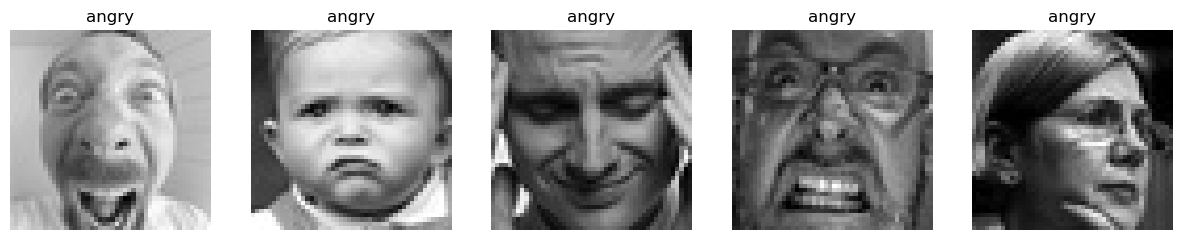

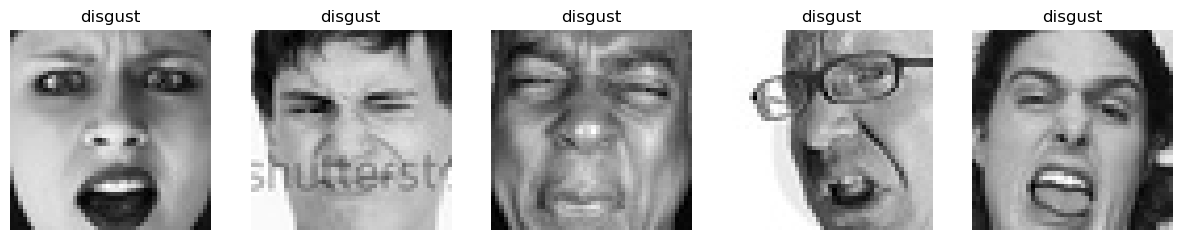

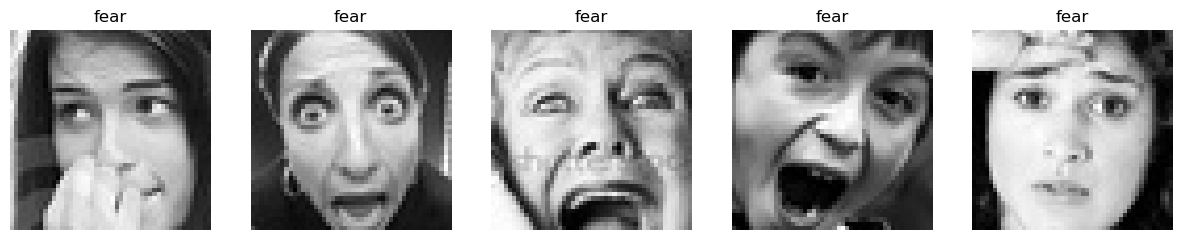

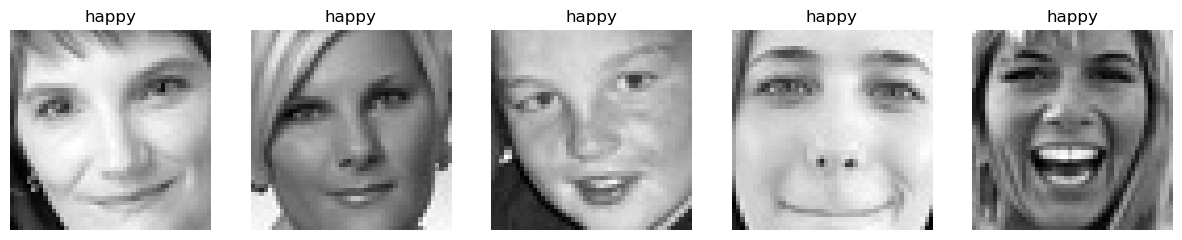

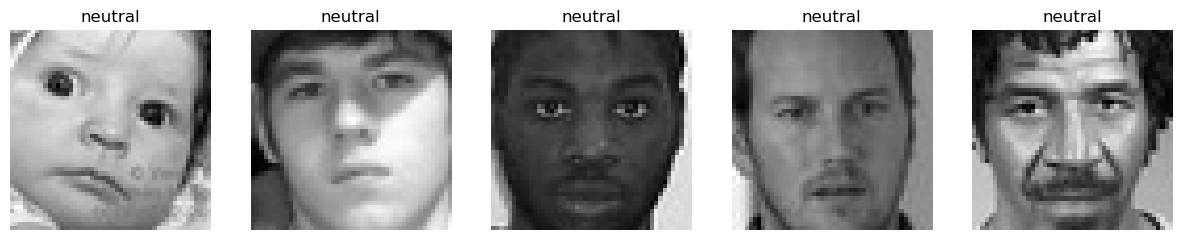

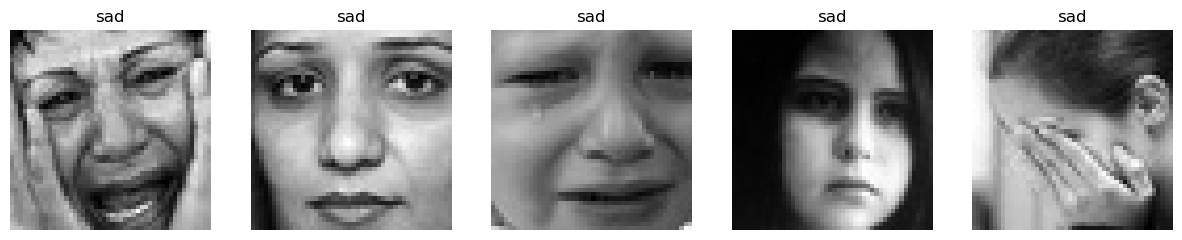

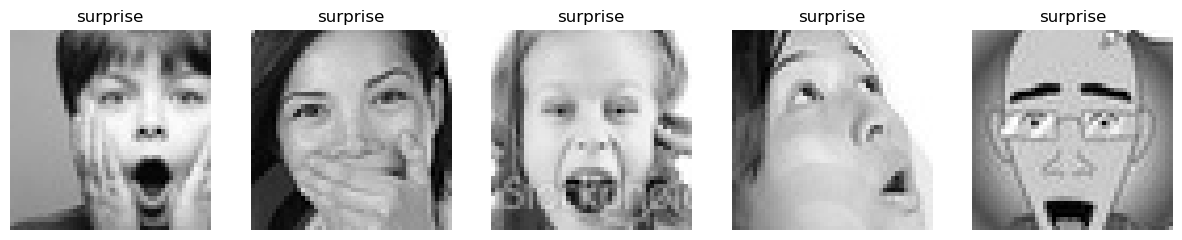

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images for each label
def plot_images_by_label(images, labels, label_encoder, num_images_per_label=5):
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        label_name = label_encoder.inverse_transform([label])[0]
        label_indices = np.where(labels == label)[0][:num_images_per_label]

        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(label_indices):
            plt.subplot(1, num_images_per_label, i + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.title(label_name)
            plt.axis('off')
        plt.show()

# Plot images for each label
plot_images_by_label(images, encoded_labels, label_encoder, num_images_per_label=5)


### CNN

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Reshape images to (num_samples, width, height, channels)
train_images = train_images.reshape(-1, 48, 48, 1)
test_images = test_images.reshape(-1, 48, 48, 1)

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(test_images, test_labels))


Epoch 1/20
188/188 [==============================] - 6s 34ms/step - loss: 1.5106 - accuracy: 0.4870 - val_loss: 0.9788 - val_accuracy: 0.5207
Epoch 2/20
188/188 [==============================] - 6s 34ms/step - loss: 0.9208 - accuracy: 0.5502 - val_loss: 0.9053 - val_accuracy: 0.5793
Epoch 3/20
188/188 [==============================] - 6s 34ms/step - loss: 0.8561 - accuracy: 0.5934 - val_loss: 0.8317 - val_accuracy: 0.6177
Epoch 4/20
188/188 [==============================] - 7s 36ms/step - loss: 0.8118 - accuracy: 0.6234 - val_loss: 0.8256 - val_accuracy: 0.6300
Epoch 5/20
188/188 [==============================] - 6s 34ms/step - loss: 0.7743 - accuracy: 0.6421 - val_loss: 0.8123 - val_accuracy: 0.6303
Epoch 6/20
188/188 [==============================] - 7s 37ms/step - loss: 0.7398 - accuracy: 0.6608 - val_loss: 0.7854 - val_accuracy: 0.6530
Epoch 7/20
188/188 [==============================] - 8s 42ms/step - loss: 0.7162 - accuracy: 0.6713 - val_loss: 0.8010 - val_accuracy: 0.6540

In [25]:
# Evaluate the model on the test set
predictions = model.predict(test_images)
predicted_labels = label_encoder.inverse_transform(tf.argmax(predictions, axis=1))
true_labels = label_encoder.inverse_transform(tf.argmax(test_labels, axis=1))

# Print the classification report
print(classification_report(true_labels, predicted_labels))

94/94 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

        fear       0.46      0.42      0.44       584
       happy       0.79      0.80      0.80      1456
         sad       0.59      0.62      0.60       960

    accuracy                           0.67      3000
   macro avg       0.62      0.61      0.61      3000
weighted avg       0.67      0.67      0.67      3000



94/94 [==============================] - 2s 17ms/step
Confusion matrix, without normalization
Normalized confusion matrix


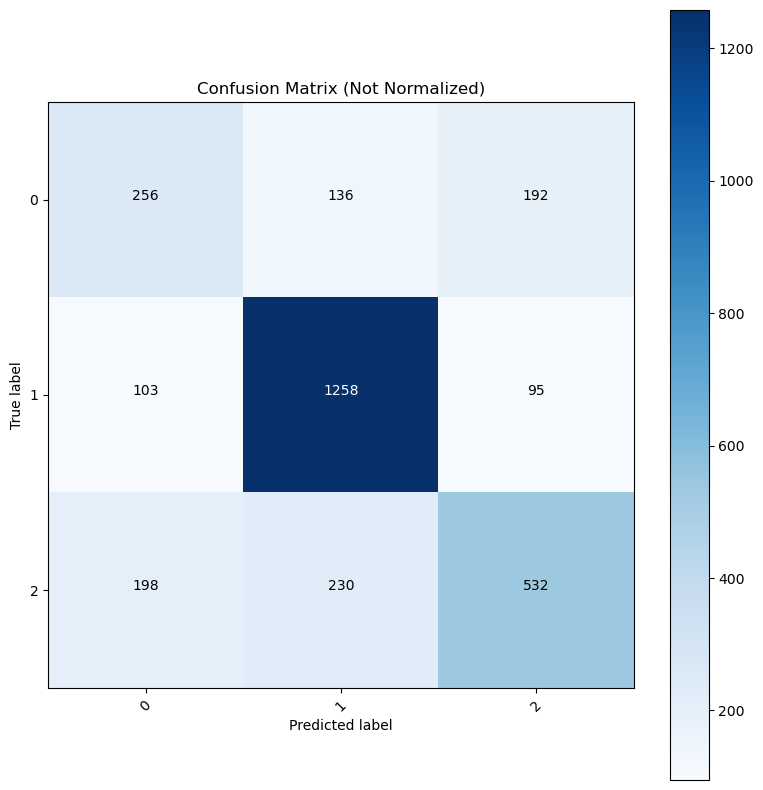

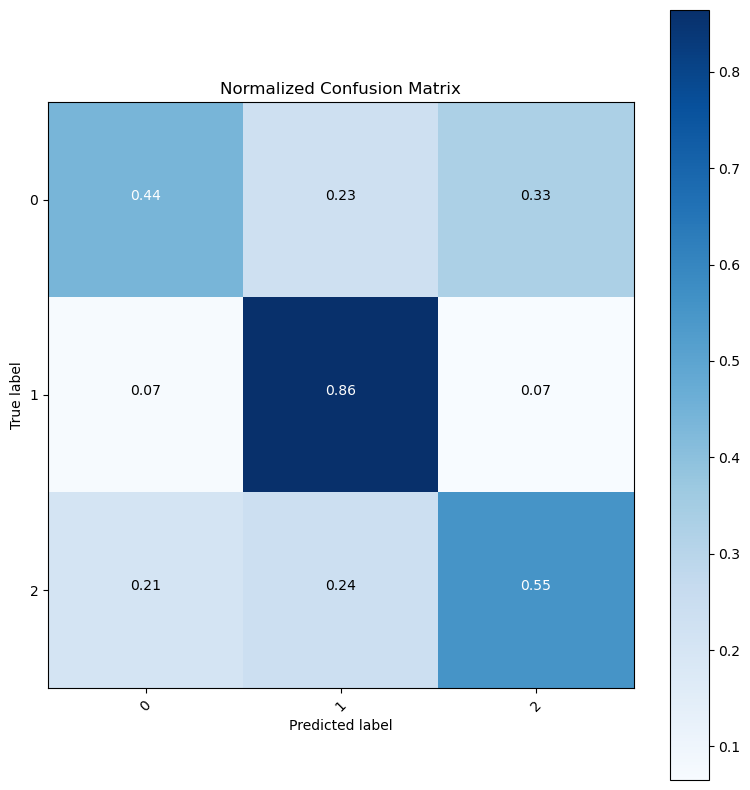

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels



# Predict labels for the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=np.unique(true_labels), title='Confusion Matrix (Not Normalized)')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=np.unique(true_labels), normalize=True, title='Normalized Confusion Matrix')

plt.show()


### CNN with Hyperparameter Tunning

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

# Build the CNN model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Adjust dropout rate
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

# Compile the model with an optimized learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model with increased epochs
model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=10,  # Increase the number of epochs
    validation_data=(test_images, test_labels)
)


Epoch 1/10
188/188 [==============================] - 24s 127ms/step - loss: 1.6692 - accuracy: 0.4537 - val_loss: 1.0338 - val_accuracy: 0.4913
Epoch 2/10
188/188 [==============================] - 24s 127ms/step - loss: 1.0086 - accuracy: 0.5152 - val_loss: 0.9835 - val_accuracy: 0.5250
Epoch 3/10
188/188 [==============================] - 25s 134ms/step - loss: 0.9237 - accuracy: 0.5552 - val_loss: 0.9068 - val_accuracy: 0.6017
Epoch 4/10
188/188 [==============================] - 26s 139ms/step - loss: 0.8682 - accuracy: 0.5900 - val_loss: 0.7854 - val_accuracy: 0.6423
Epoch 5/10
188/188 [==============================] - 25s 136ms/step - loss: 0.8331 - accuracy: 0.6146 - val_loss: 0.8502 - val_accuracy: 0.6297
Epoch 6/10
188/188 [==============================] - 27s 142ms/step - loss: 0.8119 - accuracy: 0.6294 - val_loss: 1.1438 - val_accuracy: 0.4470
Epoch 7/10
188/188 [==============================] - 26s 139ms/step - loss: 0.7797 - accuracy: 0.6463 - val_loss: 0.8317 - val_ac

In [16]:
from sklearn.metrics import classification_report

# Evaluate the model and print the classification report
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print("Classification Report:\n", classification_report(true_labels, predicted_labels))


94/94 [==============================] - 2s 18ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.54      0.49       584
           1       0.70      0.90      0.78      1456
           2       0.68      0.29      0.41       960

    accuracy                           0.63      3000
   macro avg       0.61      0.58      0.56      3000
weighted avg       0.64      0.63      0.61      3000



94/94 [==============================] - 2s 17ms/step
Confusion matrix, without normalization
Normalized confusion matrix


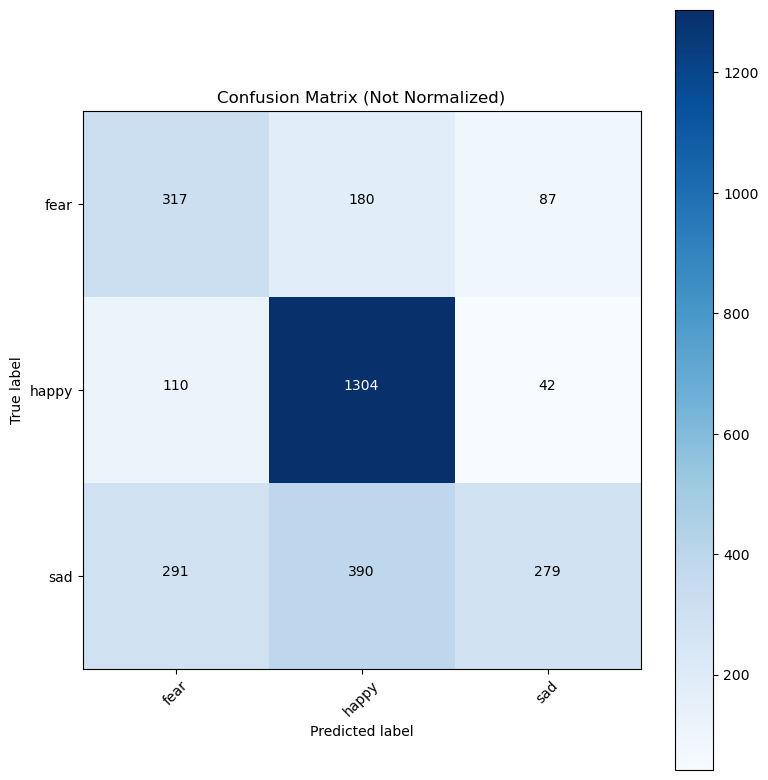

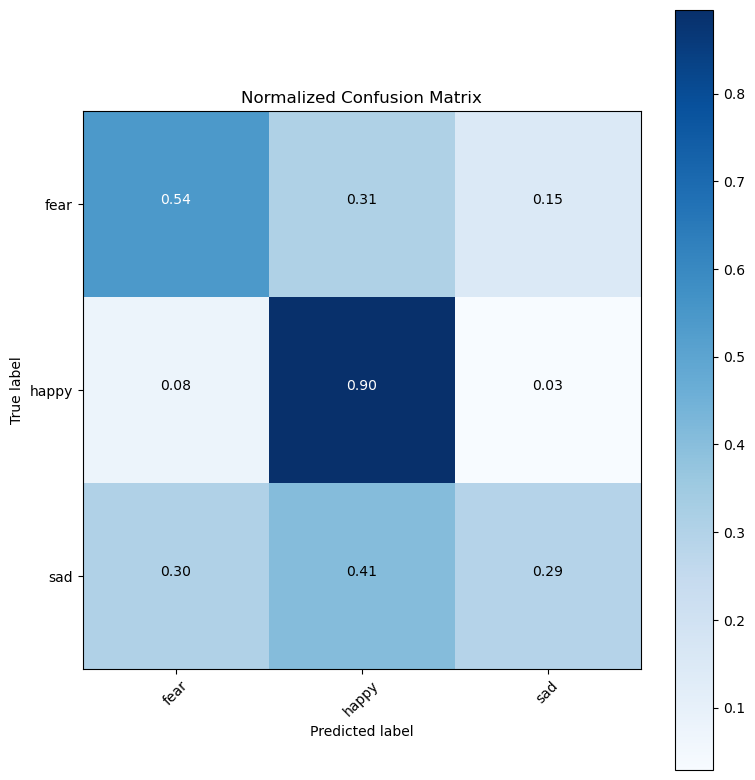

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

# Assuming your model is already trained and named 'model'

# Predict labels for the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=label_encoder.classes_, title='Confusion Matrix (Not Normalized)')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes=label_encoder.classes_, normalize=True, title='Normalized Confusion Matrix')

plt.show()


## VGG16

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Convert black and white images to RGB and resize to (224, 224)
train_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(train_images))
train_images_resized = tf.image.resize(train_images_rgb, (224, 224))

test_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_images))
test_images_resized = tf.image.resize(test_images_rgb, (224, 224))

# Step 2: Choose a pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 3: Modify the top layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  
# Optionally, freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
model.fit(train_images_resized, train_labels, epochs=10, batch_size=64, validation_data=(test_images_resized, test_labels))


Epoch 1/10
188/188 [==============================] - 1968s 10s/step - loss: 1.9520 - accuracy: 0.6154 - val_loss: 0.7781 - val_accuracy: 0.7020
Epoch 2/10
188/188 [==============================] - 2010s 11s/step - loss: 0.6455 - accuracy: 0.7297 - val_loss: 0.6849 - val_accuracy: 0.7333
Epoch 3/10
188/188 [==============================] - 1974s 11s/step - loss: 0.4608 - accuracy: 0.8027 - val_loss: 0.6394 - val_accuracy: 0.7453
Epoch 4/10
188/188 [==============================] - 1832s 10s/step - loss: 0.3278 - accuracy: 0.8577 - val_loss: 0.7447 - val_accuracy: 0.7293
Epoch 5/10
188/188 [==============================] - 1831s 10s/step - loss: 0.2511 - accuracy: 0.8901 - val_loss: 0.8384 - val_accuracy: 0.7470
Epoch 6/10
188/188 [==============================] - 1857s 10s/step - loss: 0.1824 - accuracy: 0.9248 - val_loss: 1.0007 - val_accuracy: 0.7437
Epoch 7/10
188/188 [==============================] - 1893s 10s/step - loss: 0.1447 - accuracy: 0.9442 - val_loss: 0.9931 - val_ac

94/94 [==============================] - 374s 4s/step


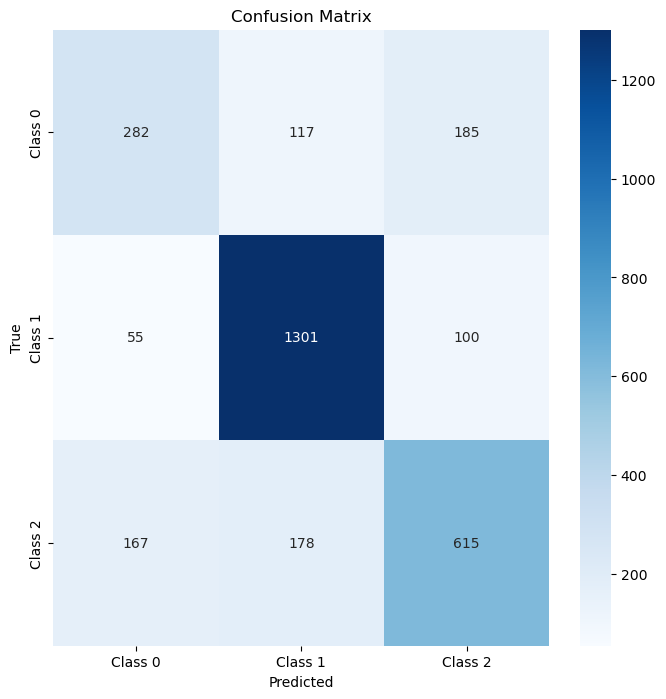

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.48      0.52       584
           1       0.82      0.89      0.85      1456
           2       0.68      0.64      0.66       960

    accuracy                           0.73      3000
   macro avg       0.69      0.67      0.68      3000
weighted avg       0.72      0.73      0.73      3000



In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Fit the label encoder on the training labels
label_encoder = LabelEncoder()
train_labels_categorical = np.argmax(train_labels, axis=1)
train_labels_categorical = label_encoder.fit_transform(train_labels_categorical)

# Assuming your labels are in one-hot encoded format, convert them back to categorical for inverse_transform
test_labels_categorical = np.argmax(test_labels, axis=1)

# Make predictions on the test set
predictions = model.predict(test_images_resized)
predicted_labels = np.argmax(predictions, axis=1)

# Convert predicted labels to categorical for inverse_transform
predicted_labels_categorical = label_encoder.inverse_transform(predicted_labels)

# Create confusion matrix
cm = confusion_matrix(test_labels_categorical, predicted_labels_categorical)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(test_labels_categorical, predicted_labels_categorical))


## Hyper parameter tuning to overcome underfitting

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Step 2: Choose a pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 3: Modify the top layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(3, activation='softmax'))  

# Optionally, freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_images_resized, train_labels, batch_size=64)

# Step 6: Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

def lr_schedule(epoch):
    return 0.001 * np.exp(-epoch / 10)

lr_scheduler = LearningRateScheduler(lr_schedule)

# Step 7: Train the model
model.fit(train_generator, epochs=10, batch_size=64, validation_data=(test_images_resized, test_labels), callbacks=[early_stopping, lr_scheduler])

# Step 8: Evaluate the model and print the classification report
predictions = model.predict(test_images_resized)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))


Epoch 1/10
188/188 [==============================] - 2269s 12s/step - loss: 3.6179 - accuracy: 0.4717 - val_loss: 0.8984 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 2356s 13s/step - loss: 0.9759 - accuracy: 0.4799 - val_loss: 0.8849 - val_accuracy: 0.4850 - lr: 9.0484e-04
Epoch 3/10
188/188 [==============================] - 2394s 13s/step - loss: 0.9632 - accuracy: 0.4863 - val_loss: 0.8279 - val_accuracy: 0.6520 - lr: 8.1873e-04
Epoch 4/10
188/188 [==============================] - 2418s 13s/step - loss: 0.9387 - accuracy: 0.5297 - val_loss: 0.8298 - val_accuracy: 0.6680 - lr: 7.4082e-04
Epoch 5/10
188/188 [==============================] - 2410s 13s/step - loss: 0.9250 - accuracy: 0.5460 - val_loss: 0.8185 - val_accuracy: 0.6713 - lr: 6.7032e-04
Epoch 6/10
188/188 [==============================] - 2380s 13s/step - loss: 0.9145 - accuracy: 0.5479 - val_loss: 0.7925 - val_accuracy: 0.6667 - lr: 6.0653e-04
Epoch 7/10
188/188 [============

## Resnet

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Assuming you have train_images, train_labels, test_images, and test_labels

# Step 1: Convert black and white images to RGB and resize to (224, 224)
train_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(train_images))
train_images_resized = tf.image.resize(train_images_rgb, (224, 224))

test_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_images))
test_images_resized = tf.image.resize(test_images_rgb, (224, 224))

# Step 2: Choose a pre-trained model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 3: Modify the top layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout for regularization
model.add(layers.Dense(3, activation='softmax'))  
# Optionally, freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images_resized, train_labels, epochs=10, batch_size=64, validation_data=(test_images_resized, test_labels))

# Step 8: Evaluate the model and print the classification report
predictions = model.predict(test_images_resized)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))


Epoch 1/10
188/188 [==============================] - 663s 4s/step - loss: 3.1874 - accuracy: 0.4695 - val_loss: 0.8613 - val_accuracy: 0.4853 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 681s 4s/step - loss: 0.9763 - accuracy: 0.4801 - val_loss: 0.8312 - val_accuracy: 0.4853 - lr: 9.0484e-04
Epoch 3/10
188/188 [==============================] - 700s 4s/step - loss: 0.9665 - accuracy: 0.4799 - val_loss: 0.8321 - val_accuracy: 0.4853 - lr: 8.1873e-04
Epoch 4/10
188/188 [==============================] - 731s 4s/step - loss: 0.9544 - accuracy: 0.4791 - val_loss: 0.8156 - val_accuracy: 0.6660 - lr: 7.4082e-04
Epoch 5/10
188/188 [==============================] - 766s 4s/step - loss: 0.9501 - accuracy: 0.4835 - val_loss: 0.8415 - val_accuracy: 0.6830 - lr: 6.7032e-04
Epoch 6/10
188/188 [==============================] - 767s 4s/step - loss: 0.9488 - accuracy: 0.4857 - val_loss: 0.8246 - val_accuracy: 0.6807 - lr: 6.0653e-04
Epoch 7/10
94/94 [==========================

/Users/navyakrishnabatchu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/navyakrishnabatchu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/navyakrishnabatchu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

94/94 [==============================] - 137s 1s/step


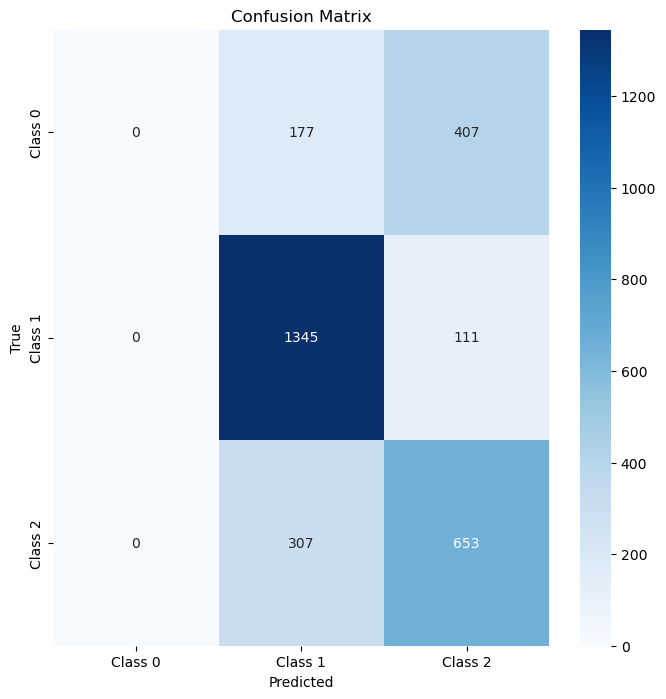

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have predictions and true labels
# Replace these with your actual predictions and labels
predictions = model.predict(test_images_resized)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (assuming 3 classes)
class_labels = ['Class 0', 'Class 1', 'Class 2']

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## resnet with hyperparameter tuning

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np


# Step 2: Choose a pre-trained model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 3: Modify the top layers
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D()) 
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Add dropout for regularization
model.add(layers.Dense(3, activation='softmax'))  # Adjust num_classes based on your dataset

# Optionally, freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(train_images_resized, train_labels, batch_size=64)

# Step 6: Early Stopping and Learning Rate Schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_schedule(epoch):
    return 0.001 * np.exp(-epoch / 10)

lr_scheduler = LearningRateScheduler(lr_schedule)

# Step 7: Train the model
model.fit(train_generator, epochs=10, batch_size=64, validation_data=(test_images_resized, test_labels), callbacks=[early_stopping, lr_scheduler])

# Step 8: Evaluate the model and print the classification report
predictions = model.predict(test_images_resized)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

print(classification_report(true_labels, predicted_labels))


Epoch 1/10
188/188 [==============================] - 741s 4s/step - loss: 0.9586 - accuracy: 0.5730 - val_loss: 0.7834 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 707s 4s/step - loss: 0.8478 - accuracy: 0.6201 - val_loss: 0.7537 - val_accuracy: 0.6797 - lr: 9.0484e-04
Epoch 3/10
188/188 [==============================] - 733s 4s/step - loss: 0.8169 - accuracy: 0.6417 - val_loss: 0.7393 - val_accuracy: 0.6837 - lr: 8.1873e-04
Epoch 4/10
188/188 [==============================] - 756s 4s/step - loss: 0.7901 - accuracy: 0.6541 - val_loss: 0.7159 - val_accuracy: 0.6960 - lr: 7.4082e-04
Epoch 5/10
188/188 [==============================] - 778s 4s/step - loss: 0.7754 - accuracy: 0.6620 - val_loss: 0.7134 - val_accuracy: 0.7003 - lr: 6.7032e-04
Epoch 6/10
188/188 [==============================] - 790s 4s/step - loss: 0.7612 - accuracy: 0.6689 - val_loss: 0.6907 - val_accuracy: 0.7090 - lr: 6.0653e-04
Epoch 7/10
188/188 [========================

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = true_labels
y_pred = predicted_labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[ 191  184  209]
 [  26 1352   78]
 [  90  281  589]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.33      0.43       584
           1       0.74      0.93      0.83      1456
           2       0.67      0.61      0.64       960

    accuracy                           0.71      3000
   macro avg       0.68      0.62      0.63      3000
weighted avg       0.70      0.71      0.69      3000



In [34]:
!pip install opencv-python numpy scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 475.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 306.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 MB 1.3 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 1.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.3/400.3 kB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 1.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━